# An example of "Seasonal, Trend decomposition using Loess" (STL) on Dow Jones

STL is a robust method for decomposing a time series into three components: periodic seasonal values, a trend over periods, and a residual term.  The trend is found by using a non-linear "Loess" smoother. This notebook shows a STL decomposition transform that can be used in a forecast pipeline applied to public company quarterly revenue data. We demonstrate how to use the statsmodels' `seasonal_decompose` method to generate  and display the three components for each time series.

In [137]:
# Import the needed components
import warnings
# Suppress warnings
warnings.filterwarnings("ignore") 

import math
import pkg_resources
from datetime import timedelta
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('agg')
%matplotlib inline
from matplotlib import pyplot as plt

# The STL algorithm
from statsmodels.tsa.seasonal import seasonal_decompose

# Featurizers from FTK
from ftk import AzureMLForecastPipeline
# from ftk.data import load_dow_jones_dataset
from ftk.transforms import TimeIndexFeaturizer
# Sigh.  An orphan extracted from the base package
from ftwrapper import FunctionTransformerWrapper

## Load Company Quarterly Data
We load the public Dow Jones data and extract the time series by company.

In [138]:
from ftk.data import load_dow_jones_dataset
train_df, test_df = load_dow_jones_dataset()

grain_list = ['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DD', 'DIS', 'GE', 'IBM', 'JNJ',  'KO', 'MCD', 'MMM', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'VZ', 'WMT', 'XOM']
train_df = train_df[train_df.grain_index.isin(grain_list)]
train_df.head()

,,revenue
quarter_start,company_ticker,
2000-01-01,AAPL,1945.00
2000-04-01,AAPL,1825.00
2000-07-01,AAPL,1870.00
2000-10-01,AAPL,1007.00
2001-01-01,AAPL,1431.00


## Plots of STL decomposition by company

Below are the pairs of decomposition plots for each company. The first plot shows the smoothed trend compared to the actual data. The second plot shows the periodic seasonal factor and the residual as multiplicative values that together explain the difference between the actual and trend data. By generating decompositions where seasonality is strong, predictions consider each component separately. After the plots we show how to incorporate STL decomposition of a time-series as a featurizer for a time-series dataframe. 


### decompose_one()

The `freq` argument of `seasonal_decompose()` refers to the seasonality of the data in the unit of time periods. Since this data is quarterly, we assume a seasonality of 4. The `model` argument can be "additive" or "multiplicative." The latter seems to fit this data better, in our experience.

In [139]:

def decompose_one(the_df, the_ticker, the_freq=4, model_type='multiplicative'):
    train_one = the_df[the_df.grain_index.isin([the_ticker])]
    series_vals = train_one[train_one.ts_value_colname].values
    result = seasonal_decompose(series_vals, model=model_type, freq=the_freq)
    date_index = train_one.reset_index()
    # result
    plt.figure(figsize=(14,12))
    plt.subplot(2,1,1)
    plt.plot(date_index.index, result.trend)
    plt.plot(date_index.index, result.observed)
    plt.legend(['Trend', 'Observed'])
    plt.title(the_ticker)
    plt.subplot(2,1,2)
    plt.plot(date_index.index, result.seasonal)
    plt.plot(date_index.index, result.resid)
    plt.legend(['Seasonal', 'Residual'])
    plt.show()


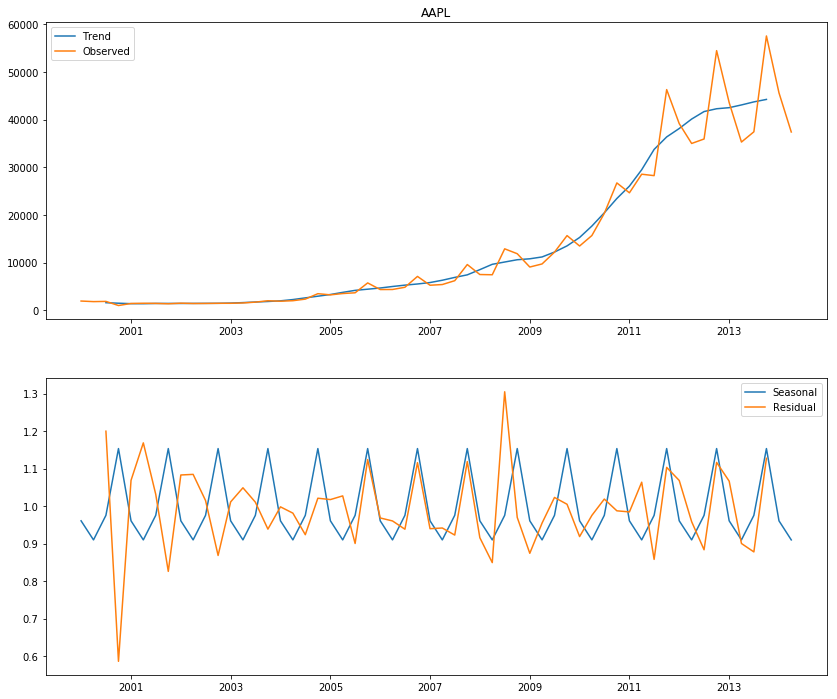

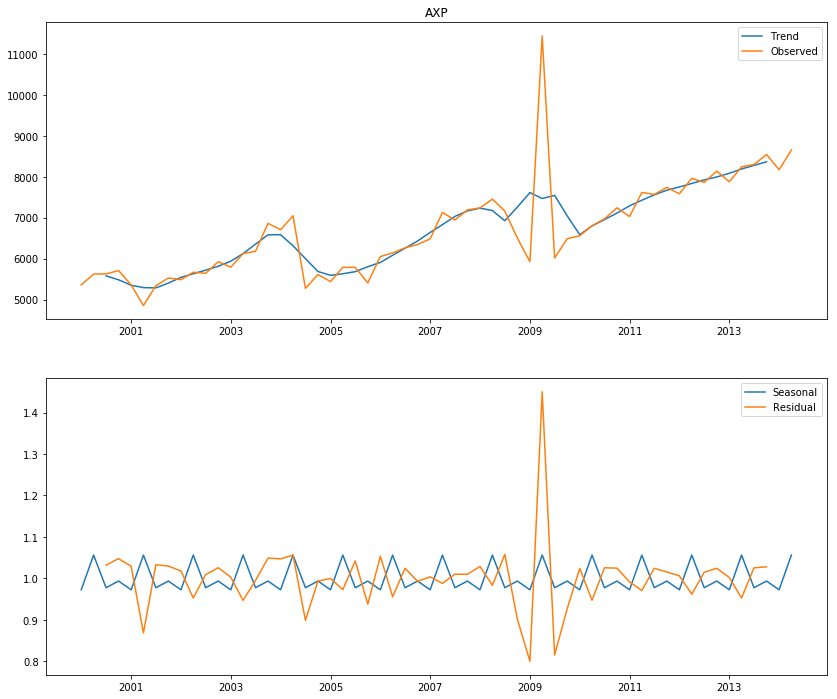

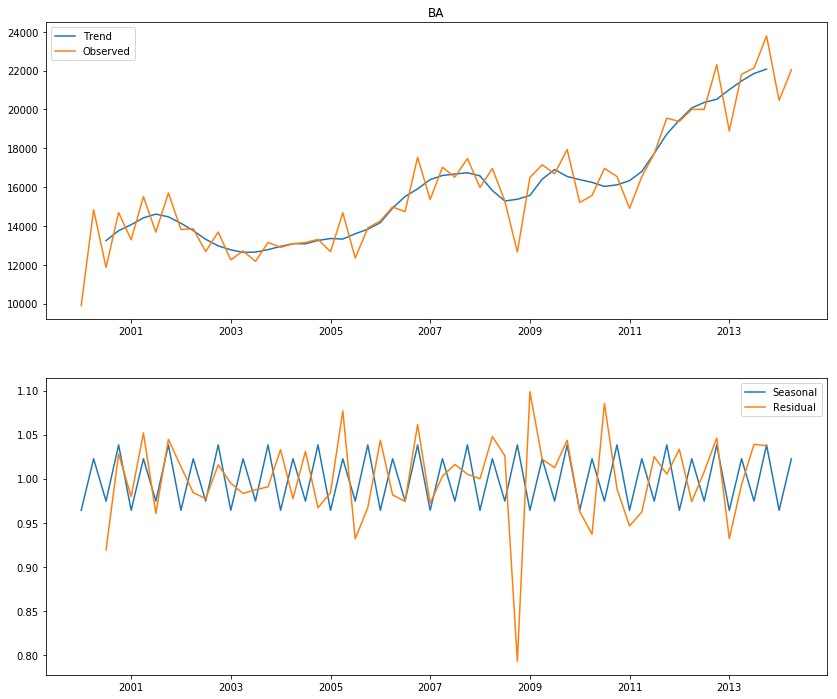

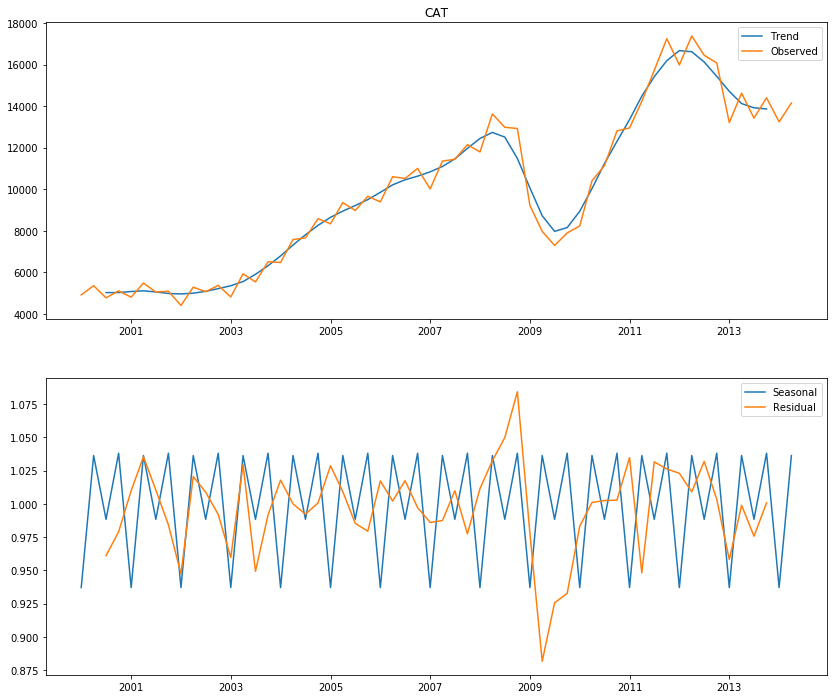

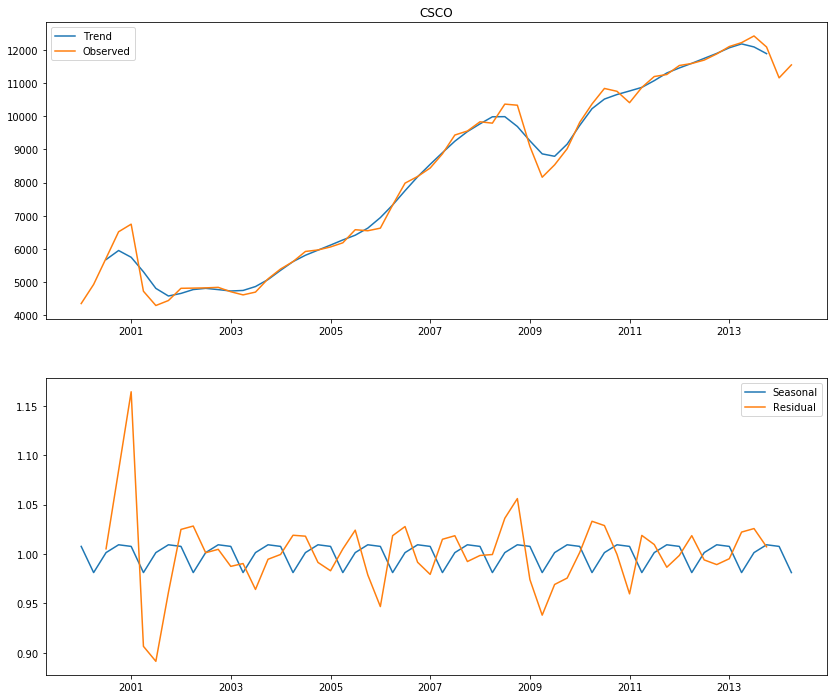

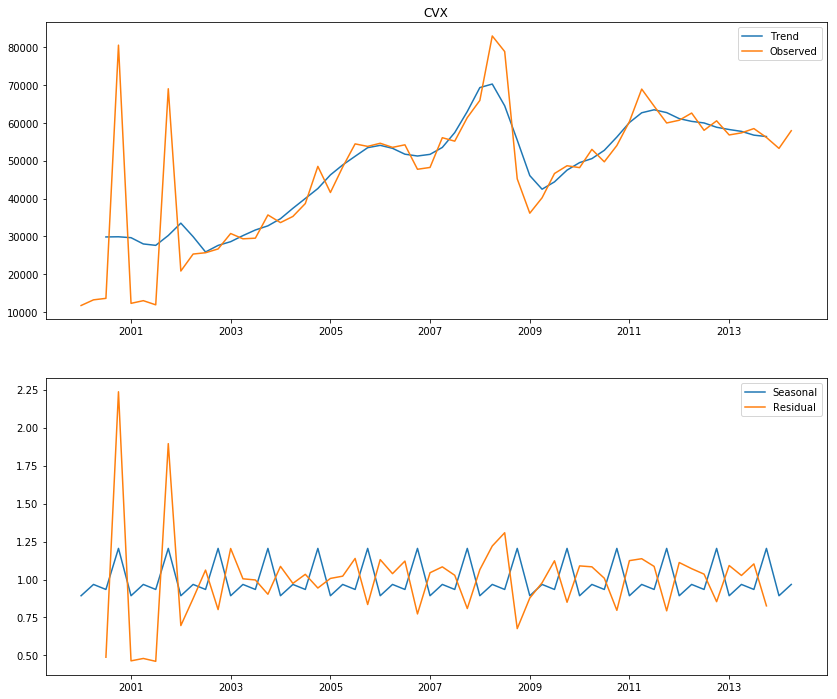

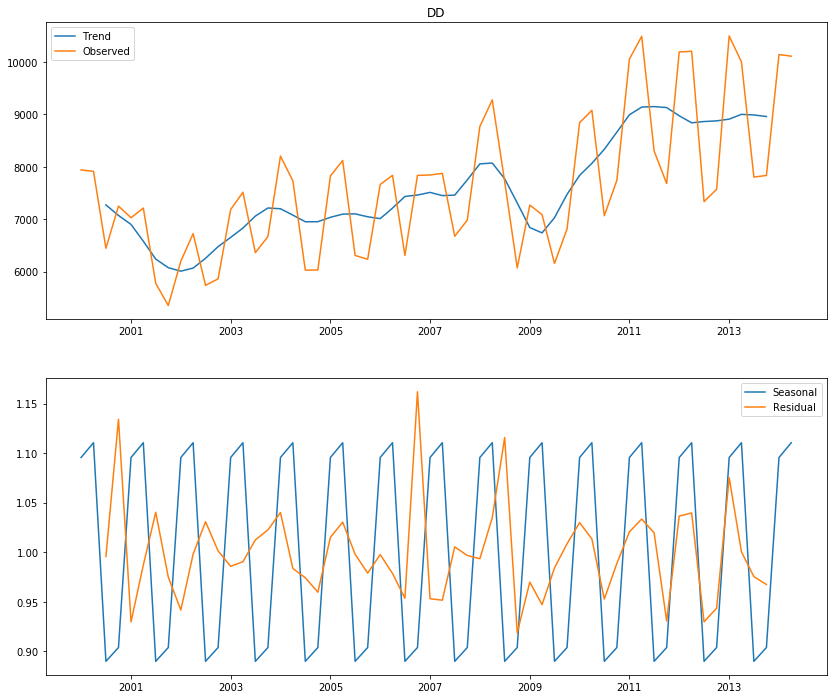

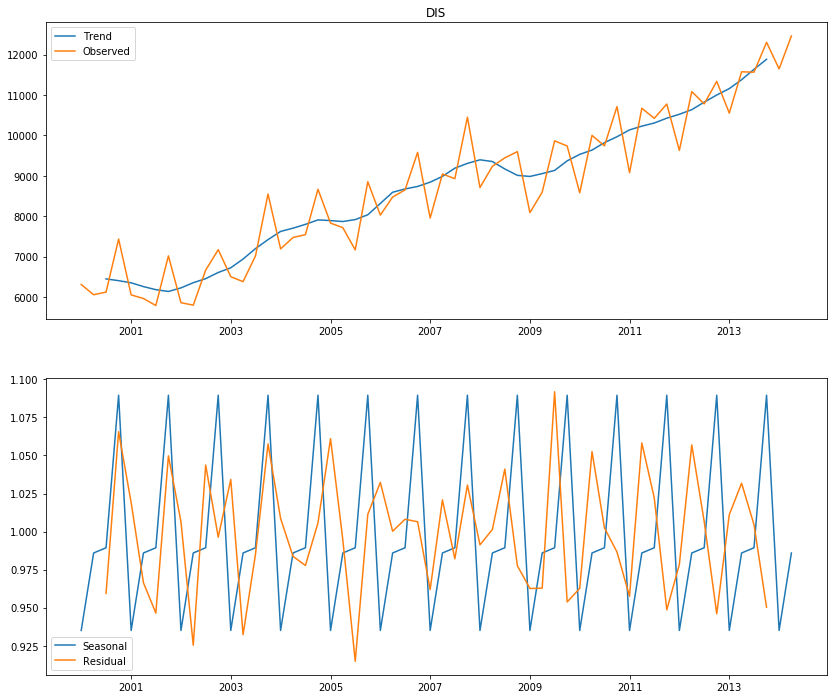

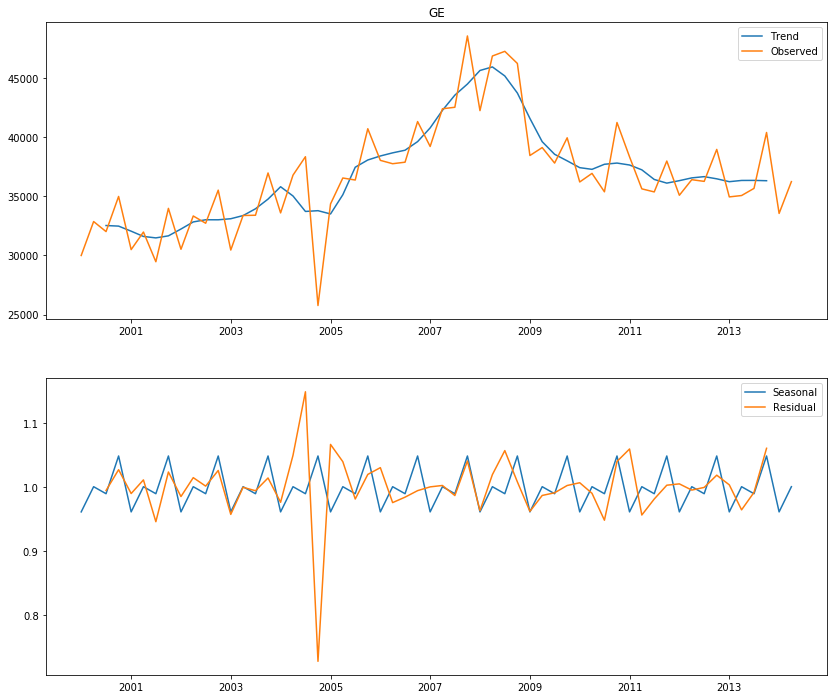

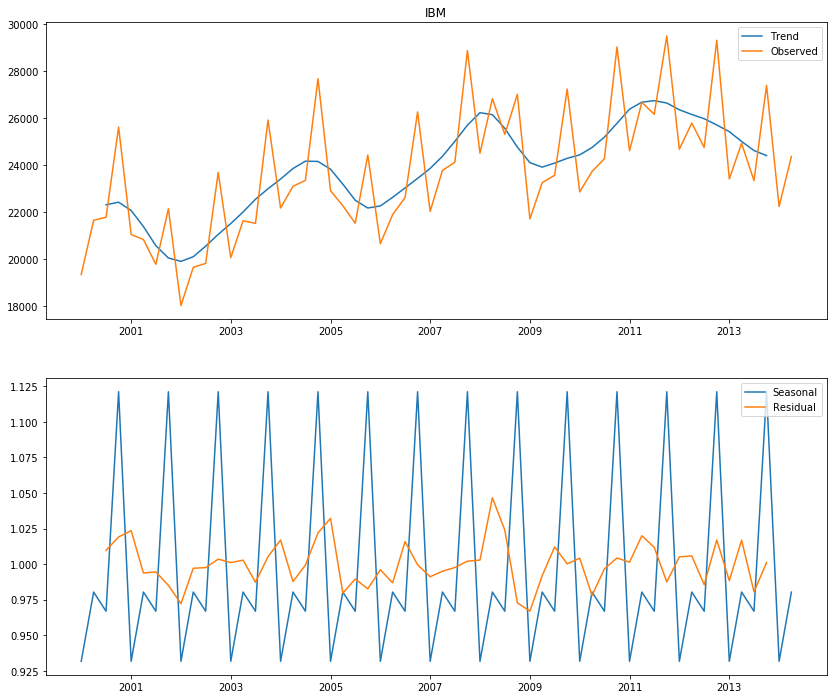

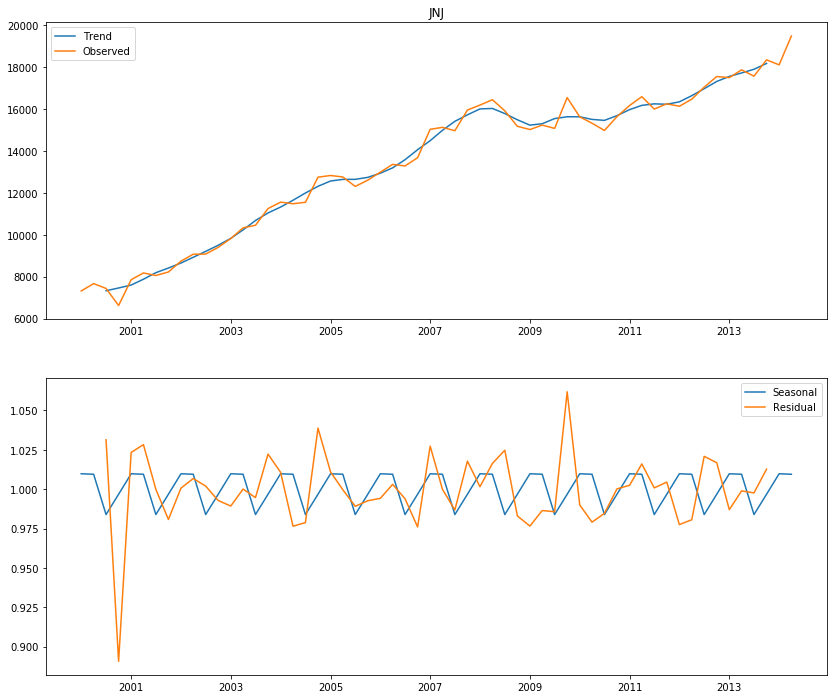

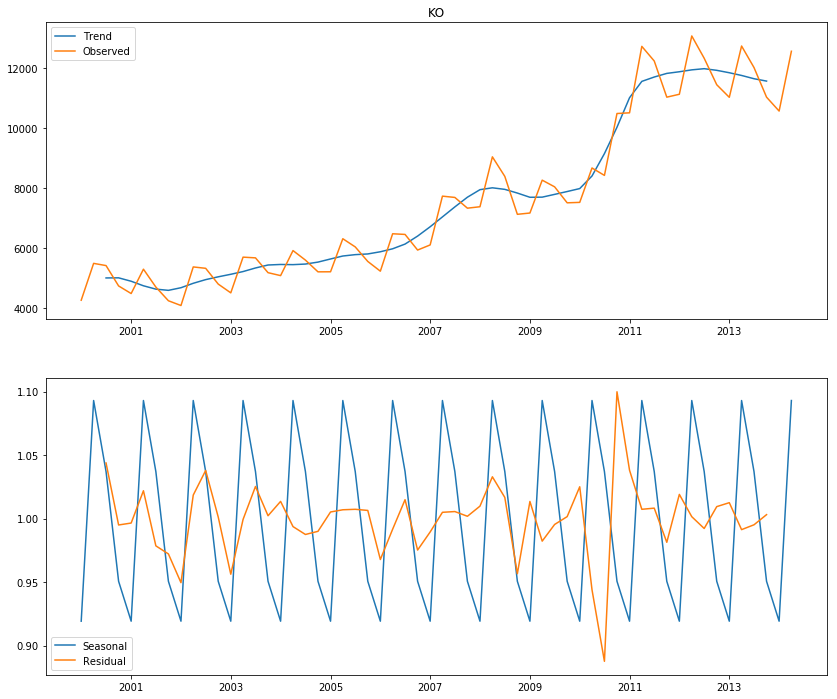

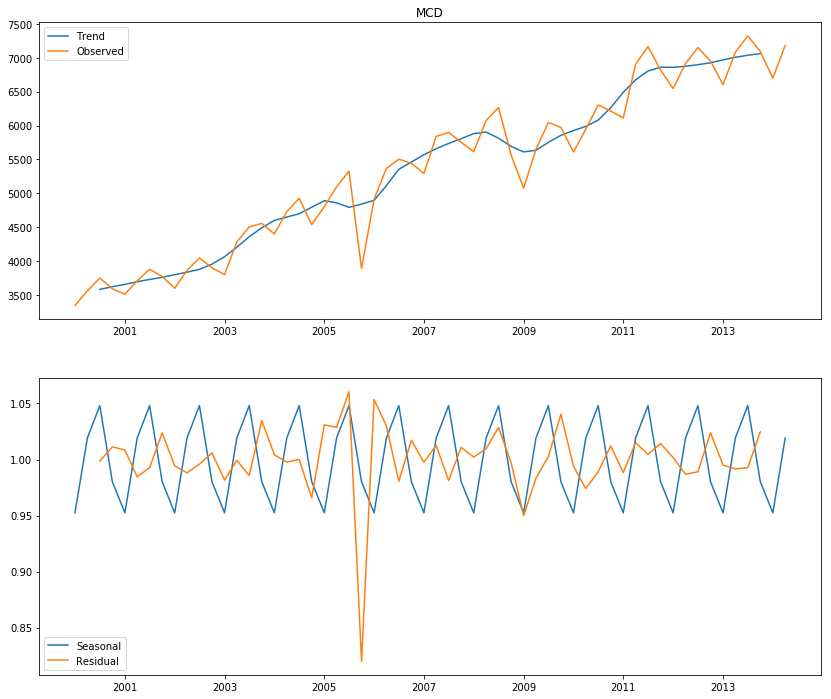

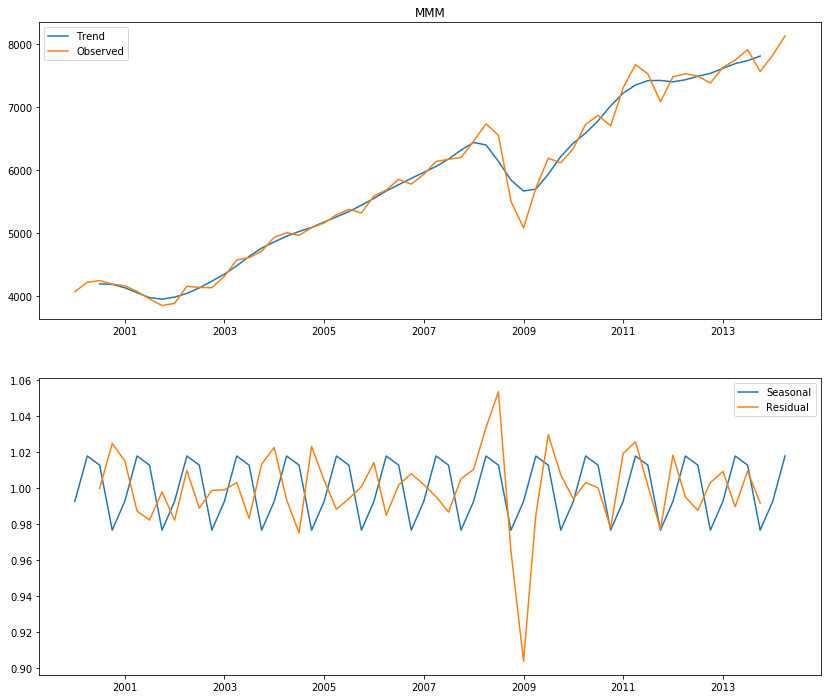

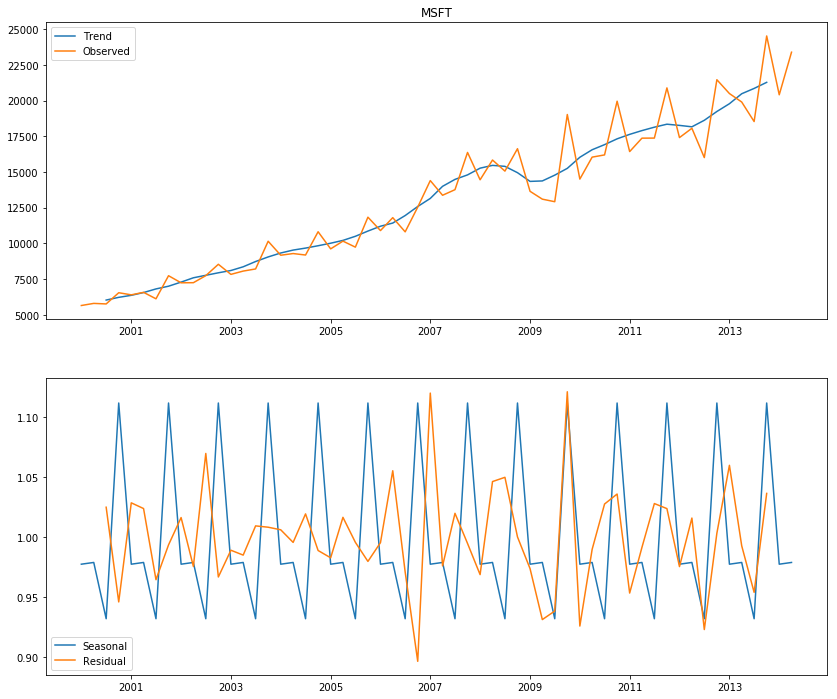

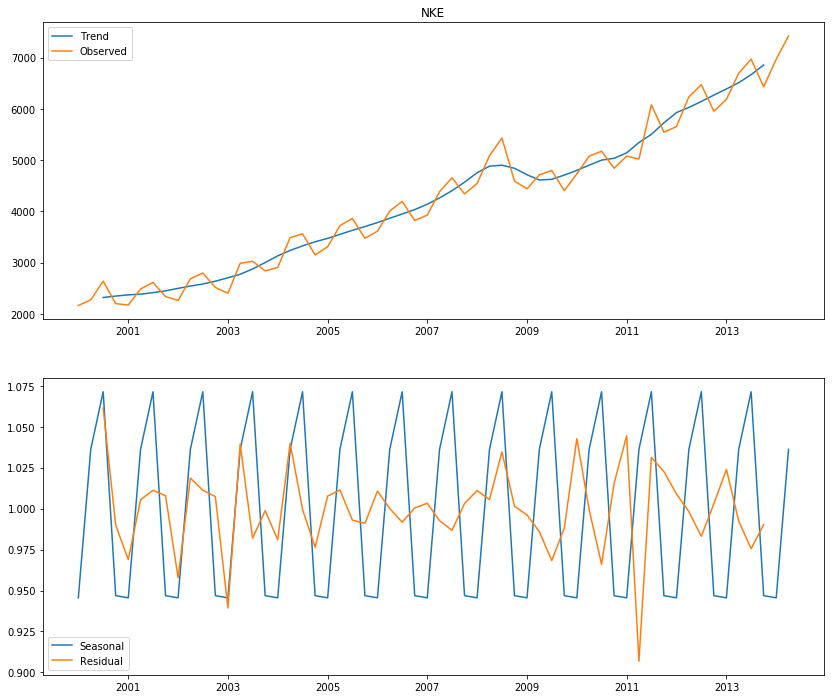

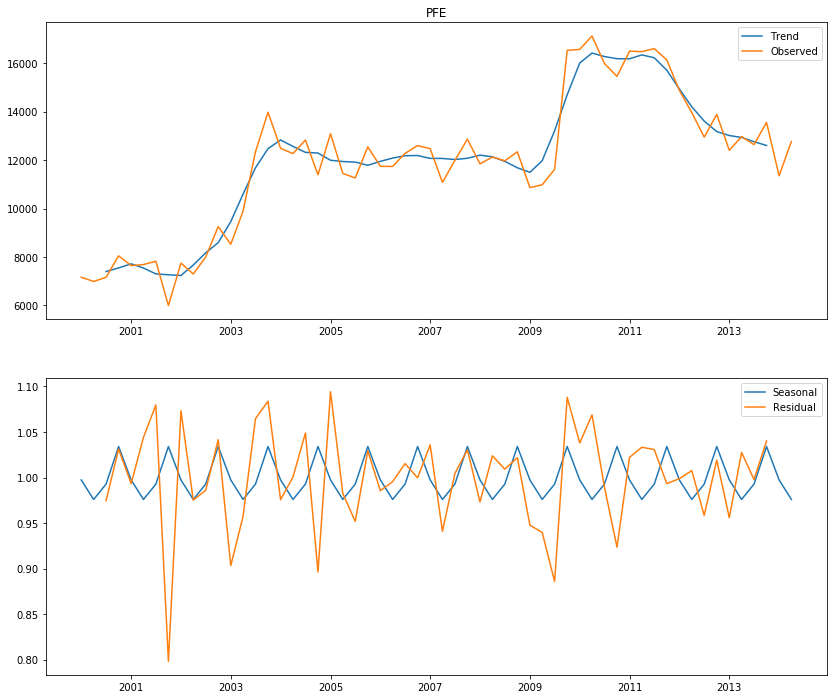

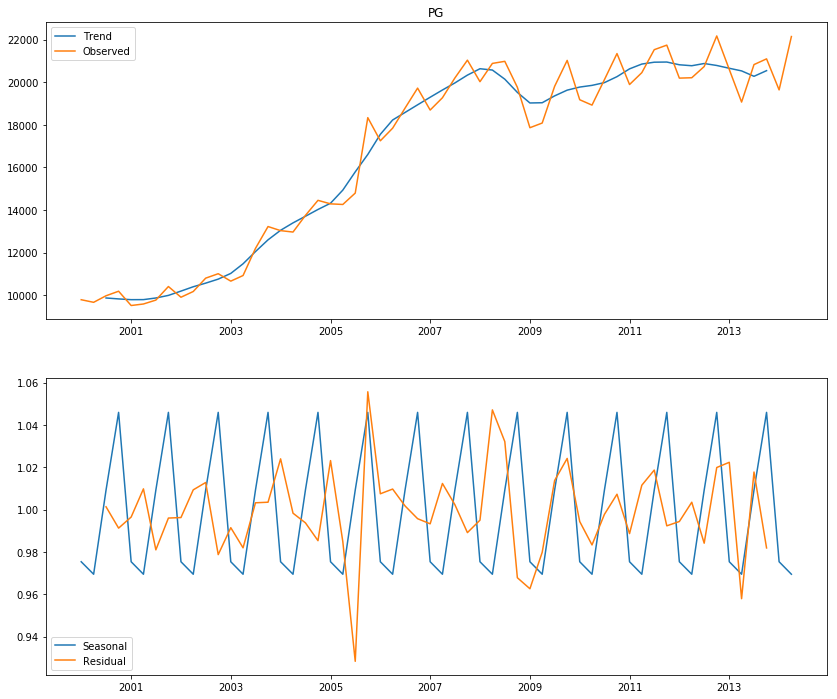

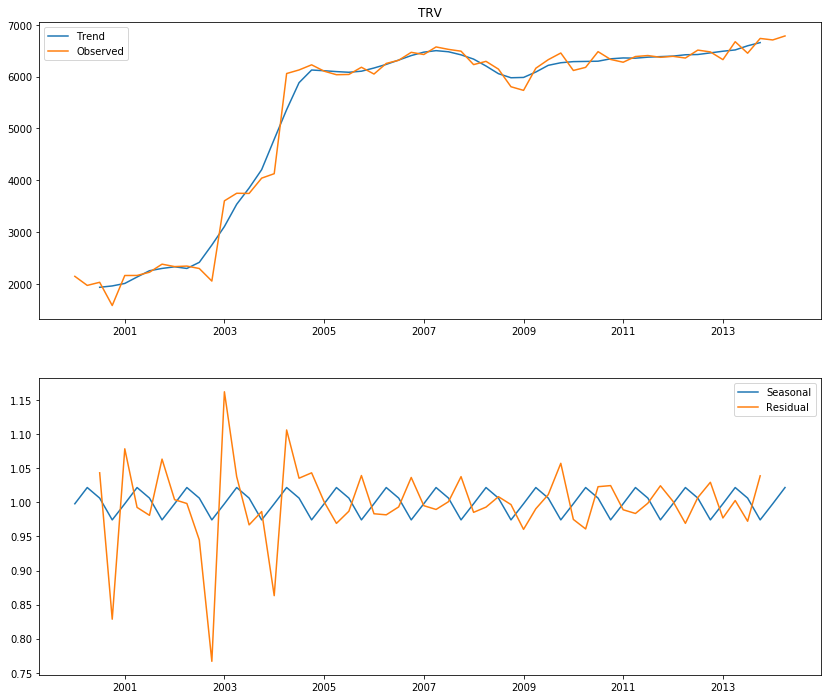

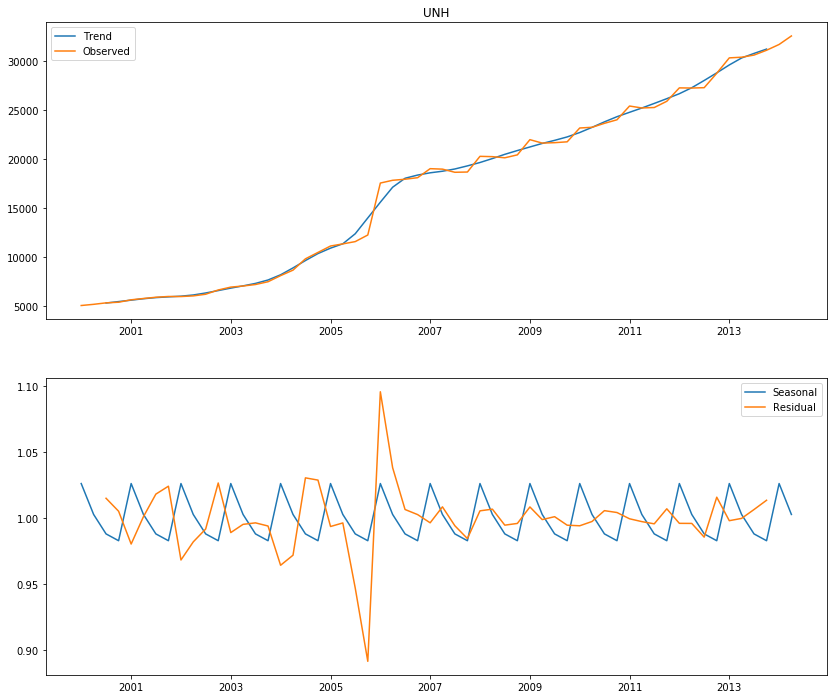

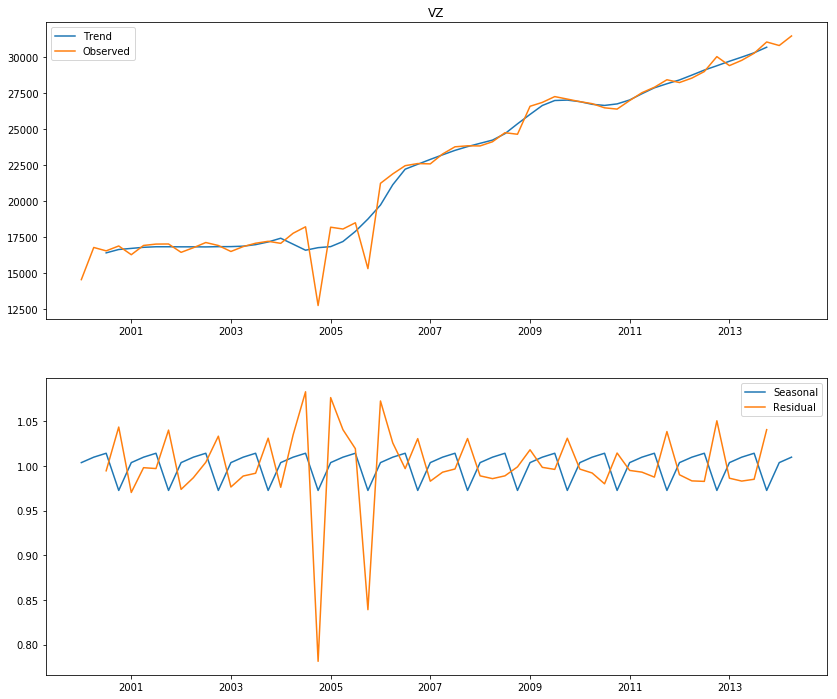

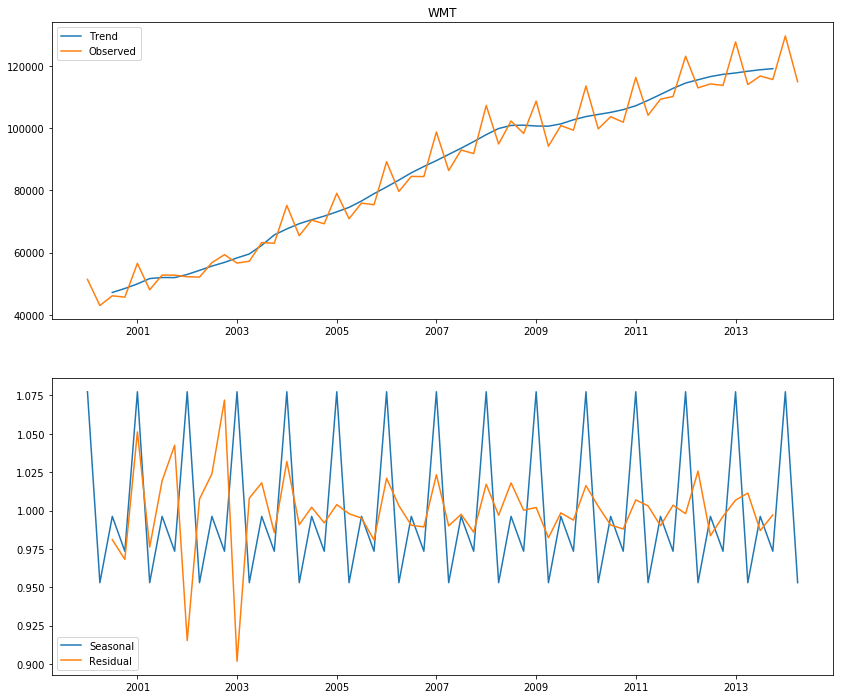

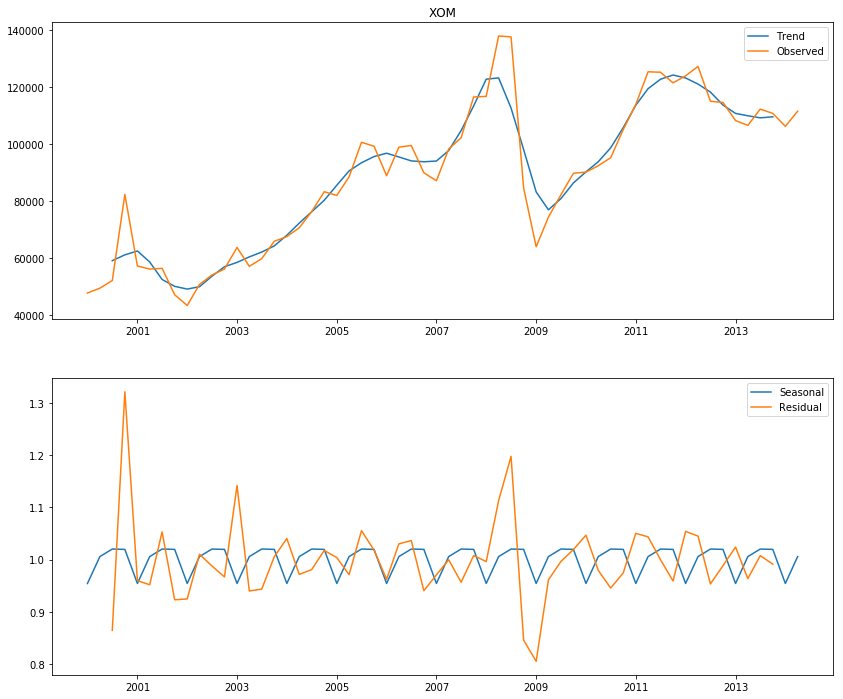

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [140]:
[decompose_one(train_df, nm) for nm in grain_list ]

## Make a Transform Object
Here, we define a function, `stl_func`, that adds trend and seasonal component columns to an input `TimeSeriesDataFrame`. Since a `TimeSeriesDataFrame` can contain multiple time series, we first write a helper function which creates the component columns for a single time series (i.e. a single grain of the data frame). Finally, we create a transform by wrapping `stl_func` with a `FunctionTransformerWrapper`. 

In [141]:
def stl_one_grain(df_one, model_type, seasonality):
    series_vals = df_one[df_one.ts_value_colname].values
    stl_result = seasonal_decompose(series_vals, model=model_type, freq=seasonality)
    
    season_name = df_one.ts_value_colname + '_season'
    trend_name = df_one.ts_value_colname + '_trend'
    
    assign_dict = {season_name: stl_result.seasonal, 
                   trend_name: stl_result.trend}
    return df_one.assign(**assign_dict)

def stl_func(df, model_type='multiplicative', seasonality=4):
    df_stl = (df.groupby_grain()
              .apply(lambda df_one: 
                  stl_one_grain(df_one, model_type, seasonality)))
    return df_stl

stl_transform = FunctionTransformerWrapper(stl_func)

Now we create a pipeline with two transform steps: a time index featurizer that creates time-based features and the STL transform. Running the `fit_transform` method produces a new `TimeSeriesDataFrame` with the desired features. We print the first 4 rows for both series in the data frame.

In [142]:
pline = AzureMLForecastPipeline(
    steps=[('time_index', TimeIndexFeaturizer()),
          ('stl_decomp', stl_transform)])

train_features_df = pline.fit_transform(train_df)
train_features_df.groupby_grain().head(4)

,,revenue,year,half,quarter,wday,week,revenue_season,revenue_trend
quarter_start,company_ticker,,,,,,,,
2000-01-01,AAPL,1945.00,2000,1,1,5,52,0.96,nan
2000-04-01,AAPL,1825.00,2000,1,2,5,13,0.91,nan
2000-07-01,AAPL,1870.00,2000,2,3,5,26,0.98,1597.50
2000-10-01,AAPL,1007.00,2000,2,4,6,39,1.15,1489.50
2000-01-01,AXP,5358.00,2000,1,1,5,52,0.97,nan
2000-04-01,AXP,5625.00,2000,1,2,5,13,1.06,nan
2000-07-01,AXP,5629.00,2000,2,3,5,26,0.98,5580.25
2000-10-01,AXP,5709.00,2000,2,4,6,39,0.99,5484.12
2000-01-01,BA,9910.00,2000,1,1,5,52,0.96,nan
